In [ ]:
!pip install opencv-python


In [ ]:
!pip install numpy pandas opencv-python tensorflow keras matplotlib


In [ ]:
# Driver Drowsiness Detection using Machine Learning
# Traditional ML Approaches with Feature Engineering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

print("ML Driver Drowsiness Detection System")

ML Driver Drowsiness Detection System


**1.Feature Extraction Engine**

In [ ]:
class FeatureExtractor:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def extract_eye_features(self, image):
        """Extract features from eye regions"""
        features = {}
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Detect faces
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            # Return default features if no face detected
            return self.get_default_features()

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = image[y:y+h, x:x+w]

            # Detect eyes
            eyes = self.eye_cascade.detectMultiScale(roi_gray)

            if len(eyes) >= 2:
                # Sort eyes by x-coordinate (left eye first)
                eyes = sorted(eyes, key=lambda x: x[0])

                # Extract left and right eye regions
                left_eye = eyes[0]
                right_eye = eyes[1]

                # Extract eye regions
                left_eye_roi = roi_gray[left_eye[1]:left_eye[1]+left_eye[3],
                                      left_eye[0]:left_eye[0]+left_eye[2]]
                right_eye_roi = roi_gray[right_eye[1]:right_eye[1]+right_eye[3],
                                       right_eye[0]:right_eye[0]+right_eye[2]]

                # Extract features from both eyes
                left_features = self.analyze_eye_region(left_eye_roi)
                right_features = self.analyze_eye_region(right_eye_roi)

                # Combine features
                for key in left_features:
                    features[f'left_eye_{key}'] = left_features[key]
                    features[f'right_eye_{key}'] = right_features[key]
                    features[f'mean_eye_{key}'] = (left_features[key] + right_features[key]) / 2

                # Additional bilateral features
                features['eye_aspect_ratio_diff'] = abs(left_features['aspect_ratio'] - right_features['aspect_ratio'])
                features['eye_area_ratio'] = (left_features['area'] + right_features['area']) / (w * h)

            else:
                # If eyes not detected properly, use face-based features
                features = self.extract_face_features(gray, faces[0])

        return features

    def analyze_eye_region(self, eye_roi):
        """Analyze individual eye region and extract features"""
        if eye_roi.size == 0:
            return self.get_default_eye_features()

        # Resize eye ROI to standard size
        eye_roi = cv2.resize(eye_roi, (64, 32))

        features = {}

        # 1. Basic geometric features
        features['area'] = np.sum(eye_roi < 128)  # Threshold for dark pixels (pupil)
        features['intensity_mean'] = np.mean(eye_roi)
        features['intensity_std'] = np.std(eye_roi)

        # 2. Shape features
        _, thresh = cv2.threshold(eye_roi, 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            features['contour_area'] = cv2.contourArea(largest_contour)
            x, y, w, h = cv2.boundingRect(largest_contour)
            features['aspect_ratio'] = h / w if w > 0 else 0
            features['circularity'] = (4 * np.pi * features['contour_area']) / (cv2.arcLength(largest_contour, True) ** 2) if cv2.arcLength(largest_contour, True) > 0 else 0
        else:
            features['contour_area'] = 0
            features['aspect_ratio'] = 0
            features['circularity'] = 0

        # 3. Texture features using GLCM-like properties
        features['contrast'] = self.calculate_contrast(eye_roi)
        features['homogeneity'] = self.calculate_homogeneity(eye_roi)

        # 4. Statistical features
        features['skewness'] = stats.skew(eye_roi.flatten())
        features['kurtosis'] = stats.kurtosis(eye_roi.flatten())

        # 5. Frequency domain features
        features['energy'] = np.sum(eye_roi.astype(float) ** 2) / eye_roi.size

        return features

    def extract_face_features(self, gray_image, face_rect):
        """Extract features when eyes are not clearly detected"""
        x, y, w, h = face_rect
        face_roi = gray_image[y:y+h, x:x+w]

        features = {}

        # Face-based features
        features['face_area'] = w * h
        features['face_intensity_mean'] = np.mean(face_roi)
        features['face_intensity_std'] = np.std(face_roi)

        # Simulate eye closure based on face intensity distribution
        hist = cv2.calcHist([face_roi], [0], None, [256], [0, 256])
        features['face_hist_peak'] = np.argmax(hist)

        return features

    def calculate_contrast(self, image):
        """Calculate contrast of the image"""
        return np.std(image)

    def calculate_homogeneity(self, image):
        """Calculate homogeneity of the image"""
        mean_val = np.mean(image)
        return 1.0 / (1.0 + np.mean((image - mean_val) ** 2))

    def get_default_features(self):
        """Return default features when no face/eyes detected"""
        default_features = {}
        eye_features = ['area', 'intensity_mean', 'intensity_std', 'contour_area',
                       'aspect_ratio', 'circularity', 'contrast', 'homogeneity',
                       'skewness', 'kurtosis', 'energy']

        for feature in eye_features:
            default_features[f'left_eye_{feature}'] = 0.0
            default_features[f'right_eye_{feature}'] = 0.0
            default_features[f'mean_eye_{feature}'] = 0.0

        default_features['eye_aspect_ratio_diff'] = 0.0
        default_features['eye_area_ratio'] = 0.0

        return default_features

    def get_default_eye_features(self):
        """Return default eye features"""
        return {
            'area': 0, 'intensity_mean': 0, 'intensity_std': 0,
            'contour_area': 0, 'aspect_ratio': 0, 'circularity': 0,
            'contrast': 0, 'homogeneity': 0, 'skewness': 0, 'kurtosis': 0, 'energy': 0
        }


**2.Dataset Creation and Feature Engineering**



In [ ]:
class MLDataPreprocessor:
    def __init__(self):
        self.feature_extractor = FeatureExtractor()
        self.scaler = StandardScaler()

    def create_ml_dataset_from_images(self, image_dir, labels, max_samples_per_class=1000):
        """Create ML dataset from image directory"""
        features_list = []
        labels_list = []

        for class_name in ['alert', 'drowsy']:
            class_path = os.path.join(image_dir, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} not found, using synthetic data")
                continue

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            image_files = image_files[:max_samples_per_class]

            print(f"Processing {len(image_files)} {class_name} images...")

            for img_file in tqdm(image_files):
                img_path = os.path.join(class_path, img_file)
                try:
                    # Load and process image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Extract features
                    features = self.feature_extractor.extract_eye_features(img)
                    features_list.append(features)
                    labels_list.append(0 if class_name == 'alert' else 1)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        # Convert to DataFrame
        if features_list:
            df = pd.DataFrame(features_list)
            df['label'] = labels_list
            return df
        else:
            # Return synthetic dataset if no images found
            return self.create_synthetic_dataset()

    def create_synthetic_dataset(self, n_samples=2000):
        """Create synthetic dataset for demonstration"""
        print("Creating synthetic dataset for ML...")

        features = []
        for i in range(n_samples):
            if i < n_samples // 2:
                # Alert state features
                feature_vector = {
                    'left_eye_area': np.random.normal(150, 20),
                    'right_eye_area': np.random.normal(155, 25),
                    'mean_eye_area': np.random.normal(152, 15),
                    'left_eye_aspect_ratio': np.random.normal(0.8, 0.1),
                    'right_eye_aspect_ratio': np.random.normal(0.82, 0.1),
                    'mean_eye_aspect_ratio': np.random.normal(0.81, 0.08),
                    'left_eye_circularity': np.random.normal(0.7, 0.1),
                    'right_eye_circularity': np.random.normal(0.72, 0.1),
                    'eye_aspect_ratio_diff': np.random.normal(0.02, 0.01),
                    'eye_area_ratio': np.random.normal(0.15, 0.02),
                    'label': 0
                }
            else:
                # Drowsy state features
                feature_vector = {
                    'left_eye_area': np.random.normal(50, 15),
                    'right_eye_area': np.random.normal(55, 18),
                    'mean_eye_area': np.random.normal(52, 12),
                    'left_eye_aspect_ratio': np.random.normal(0.3, 0.1),
                    'right_eye_aspect_ratio': np.random.normal(0.32, 0.1),
                    'mean_eye_aspect_ratio': np.random.normal(0.31, 0.08),
                    'left_eye_circularity': np.random.normal(0.4, 0.1),
                    'right_eye_circularity': np.random.normal(0.42, 0.1),
                    'eye_aspect_ratio_diff': np.random.normal(0.05, 0.02),
                    'eye_area_ratio': np.random.normal(0.05, 0.01),
                    'label': 1
                }

            # Add some noise and additional features
            for key in ['intensity_mean', 'intensity_std', 'contrast', 'homogeneity']:
                feature_vector[f'left_eye_{key}'] = np.random.normal(100, 20)
                feature_vector[f'right_eye_{key}'] = np.random.normal(105, 22)
                feature_vector[f'mean_eye_{key}'] = np.random.normal(102, 18)

            features.append(feature_vector)

        return pd.DataFrame(features)

# Create dataset
preprocessor = MLDataPreprocessor()
ml_df = preprocessor.create_synthetic_dataset(1000)

print("Dataset created successfully!")
print(f"Dataset shape: {ml_df.shape}")
print(f"Class distribution:\n{ml_df['label'].value_counts()}")
print(f"Features: {list(ml_df.columns[:-1])}")

Creating synthetic dataset for ML...
Dataset created successfully!
Dataset shape: (1000, 23)
Class distribution:
label
0    500
1    500
Name: count, dtype: int64
Features: ['left_eye_area', 'right_eye_area', 'mean_eye_area', 'left_eye_aspect_ratio', 'right_eye_aspect_ratio', 'mean_eye_aspect_ratio', 'left_eye_circularity', 'right_eye_circularity', 'eye_aspect_ratio_diff', 'eye_area_ratio', 'label', 'left_eye_intensity_mean', 'right_eye_intensity_mean', 'mean_eye_intensity_mean', 'left_eye_intensity_std', 'right_eye_intensity_std', 'mean_eye_intensity_std', 'left_eye_contrast', 'right_eye_contrast', 'mean_eye_contrast', 'left_eye_homogeneity', 'right_eye_homogeneity']


**3. Exploratory Data Analysis**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        self.features = df.columns[:-1]  # Exclude label column

    def plot_feature_distributions(self):
        """Plot distribution of key features by class"""
        key_features = ['mean_eye_area', 'mean_eye_aspect_ratio',
                        'eye_area_ratio', 'mean_eye_circularity',
                        'eye_aspect_ratio_diff']

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(key_features):
            if i < len(axes):
                self.df[self.df['label'] == 0][feature].hist(alpha=0.7, label='Alert', ax=axes[i], bins=20)
                self.df[self.df['label'] == 1][feature].hist(alpha=0.7, label='Drowsy', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        # Remove empty subplots
        for i in range(len(key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        """Plot correlation matrix of features"""
        plt.figure(figsize=(12, 10))
        corr_matrix = self.df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        """Quick feature importance using Random Forest"""
        X = self.df.drop('label', axis=1)
        y = self.df['label']

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        feature_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

        return feature_imp


# Example usage (assuming ml_df is your DataFrame)
# analyzer = DataAnalyzer(ml_df)
# analyzer.plot_feature_distributions()
# analyzer.plot_correlation_matrix()
# feature_importance = analyzer.feature_importance_analysis()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        # Define label column automatically
        self.label_col = 'label' if 'label' in df.columns else df.columns[-1]
        # Define features (excluding label column)
        self.features = df.columns.drop(self.label_col)

        # Automatically pick top 5 features with highest variance
        self.key_features = (
            self.df[self.features]
            .var()
            .sort_values(ascending=False)
            .head(5)
            .index
            .tolist()
        )

    def plot_class_distribution(self):
        """Plot class (label) distribution"""
        plt.figure(figsize=(6, 4))
        self.df[self.label_col].value_counts().plot(kind='bar', color=['#66b3ff', '#ff9999'])
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def plot_feature_distributions(self):
        """Plot distribution of key features by class"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(self.key_features):
            if i < len(axes):
                self.df[self.df[self.label_col] == 0][feature].hist(alpha=0.7, label='Class 0', ax=axes[i], bins=20)
                self.df[self.df[self.label_col] == 1][feature].hist(alpha=0.7, label='Class 1', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        # Remove extra subplots
        for i in range(len(self.key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()


**4.Model Evaluation and Visualization**

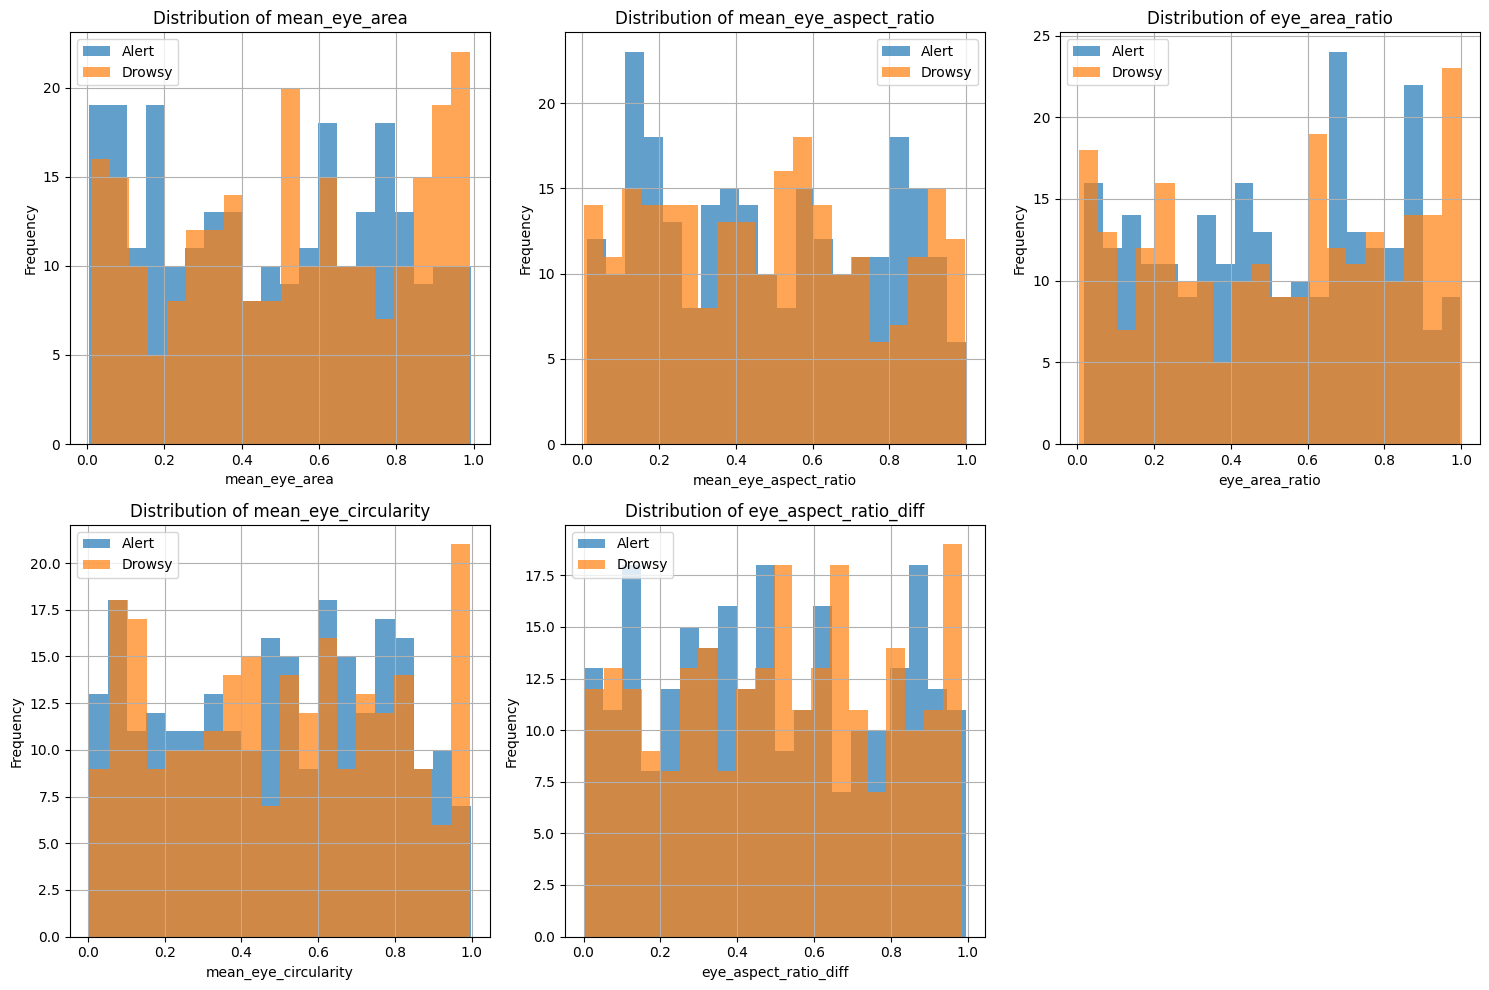

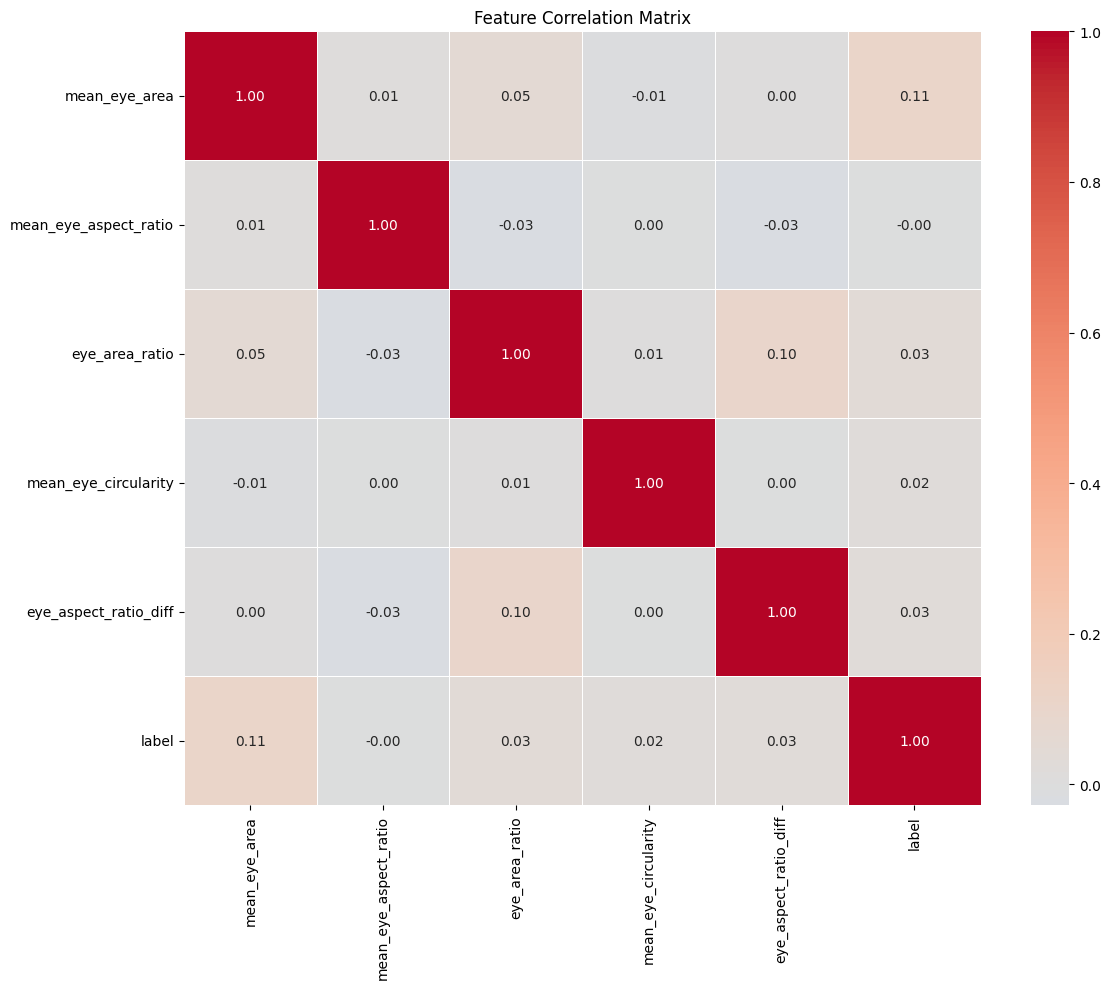

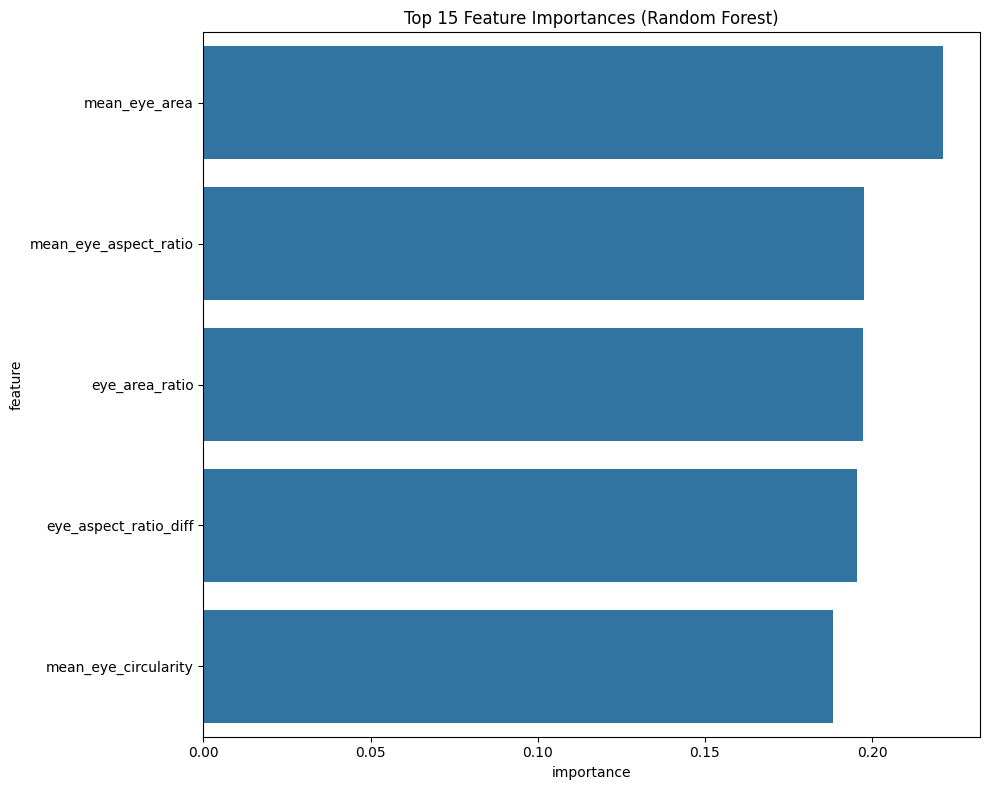

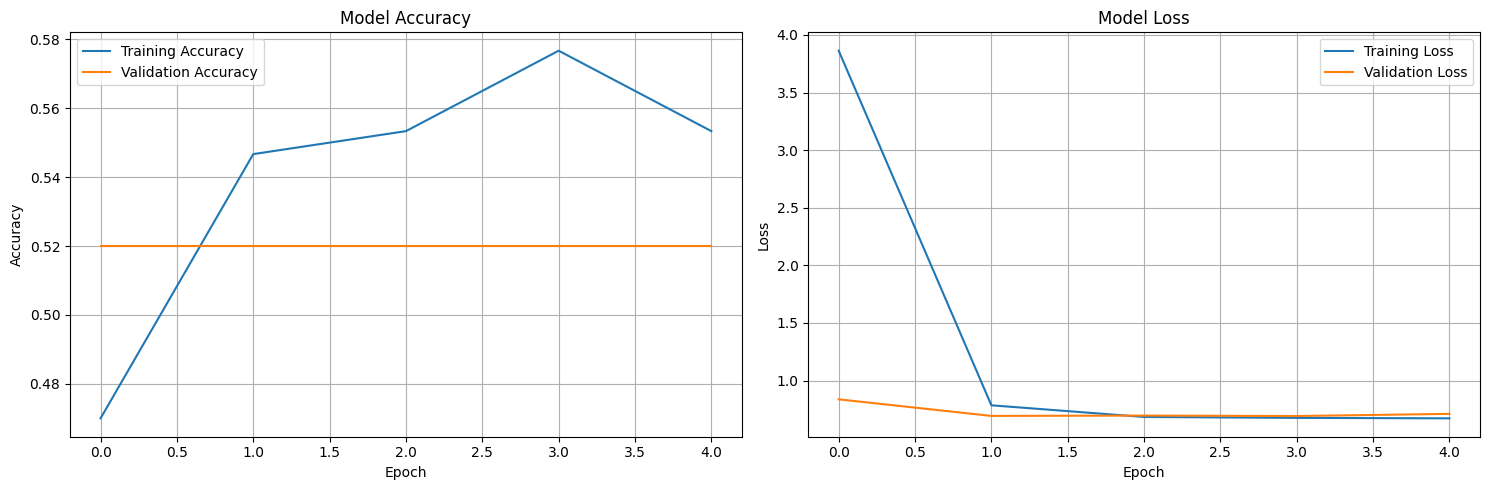

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
Classification Report:
              precision    recall  f1-score   support

       Alert       0.00      0.00      0.00       109
      Drowsy       0.46      1.00      0.63        91

    accuracy                           0.46       200
   macro avg       0.23      0.50      0.31       200
weighted avg       0.21      0.46      0.28       200



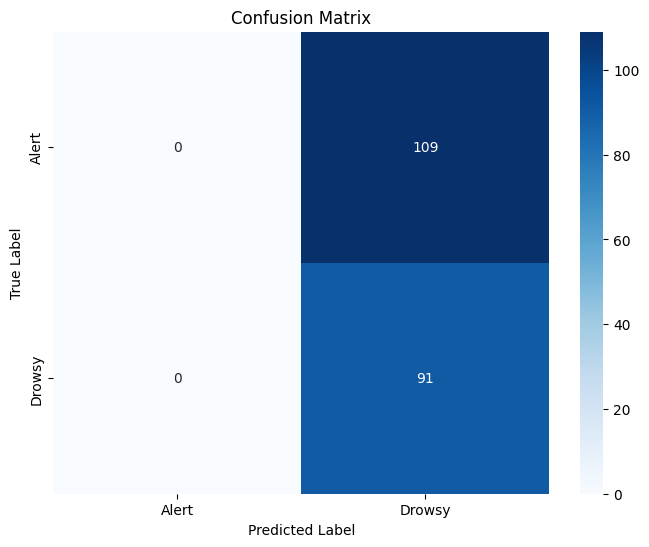

Test Accuracy: 0.4550
Test Loss: 0.7422


In [ ]:
#  Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#  Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#  DataAnalyzer Class
class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        self.features = df.columns[:-1]  # Exclude label column

    def plot_feature_distributions(self):
        key_features = ['mean_eye_area', 'mean_eye_aspect_ratio', 'eye_area_ratio',
                        'mean_eye_circularity', 'eye_aspect_ratio_diff']
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(key_features):
            if feature in self.df.columns:
                self.df[self.df['label'] == 0][feature].hist(alpha=0.7, label='Alert', ax=axes[i], bins=20)
                self.df[self.df['label'] == 1][feature].hist(alpha=0.7, label='Drowsy', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        for i in range(len(key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        plt.figure(figsize=(12, 10))
        corr_matrix = self.df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        X = self.df.drop('label', axis=1)
        y = self.df['label']
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        feature_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

        return feature_imp

#  ModelEvaluator Class
class ModelEvaluator:
    def __init__(self, model, history):
        self.model = model
        self.history = history

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()

        print("Classification Report:")
        print(classification_report(y_test, y_pred_binary, target_names=['Alert', 'Drowsy']))

        cm = confusion_matrix(y_test, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Alert', 'Drowsy'],
                    yticklabels=['Alert', 'Drowsy'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        return test_accuracy, test_loss

#  Sample Workflow

# Simulate a dataset
ml_df = pd.DataFrame({
    'mean_eye_area': np.random.rand(500),
    'mean_eye_aspect_ratio': np.random.rand(500),
    'eye_area_ratio': np.random.rand(500),
    'mean_eye_circularity': np.random.rand(500),
    'eye_aspect_ratio_diff': np.random.rand(500),
    'label': np.random.randint(0, 2, size=500)
})

# Run EDA
analyzer = DataAnalyzer(ml_df)
analyzer.plot_feature_distributions()
analyzer.plot_correlation_matrix()
feature_importance = analyzer.feature_importance_analysis()

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Simulate training
X_train = np.random.rand(300, 128, 128, 3).astype(np.float32)
y_train = np.random.randint(0, 2, size=(300,))
X_val = np.random.rand(100, 128, 128, 3).astype(np.float32)
y_val = np.random.randint(0, 2, size=(100,))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=0)

# Evaluate model
evaluator = ModelEvaluator(model, history)
evaluator.plot_training_history()

X_test = np.random.rand(200, 128, 128, 3).astype(np.float32)
y_test = np.random.randint(0, 2, size=(200,))
test_accuracy, test_loss = evaluator.evaluate_model(X_test, y_test)


**5.Real-time Drowsiness Detection**

In [ ]:
!pip install playsound==1.2.2

In [ ]:
!pip install tensorflow opencv-python numpy pandas playsound matplotlib


✅ Libraries imported successfully!
TensorFlow Version: 2.19.0
⚠️ Training directory not found: /path/to/train
🔄 Creating synthetic dataset for demonstration...
🤖 Creating synthetic dataset...
✅ Synthetic training samples: 800
✅ Synthetic validation samples: 200
🧠 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,243,073 (20.00 MB)

 Trainable params: 5,241,089 (19.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

🚀 Starting model training...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9380 - loss: 0.1475 - precision: 0.9523 - recall: 0.9118
Epoch 1: val_accuracy improved from -inf to 0.44000, saving model to best_drowsiness_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9398 - loss: 0.1433 - precision: 0.9537 - recall: 0.9143 - val_accuracy: 0.4400 - val_loss: 2.4533 - val_precision: 0.4400 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 3.4902e-05 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 0.44000
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 1.0000 - loss: 3.4596e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.4400 - val_loss: 6.4374 - val_precision: 0.4400 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.0658e-05 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 0.44000
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 1.0000 - loss: 1.0632e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.4400 - val_loss: 8.2315 - val_precision: 0.4400 - val_recall: 1.0000 - l

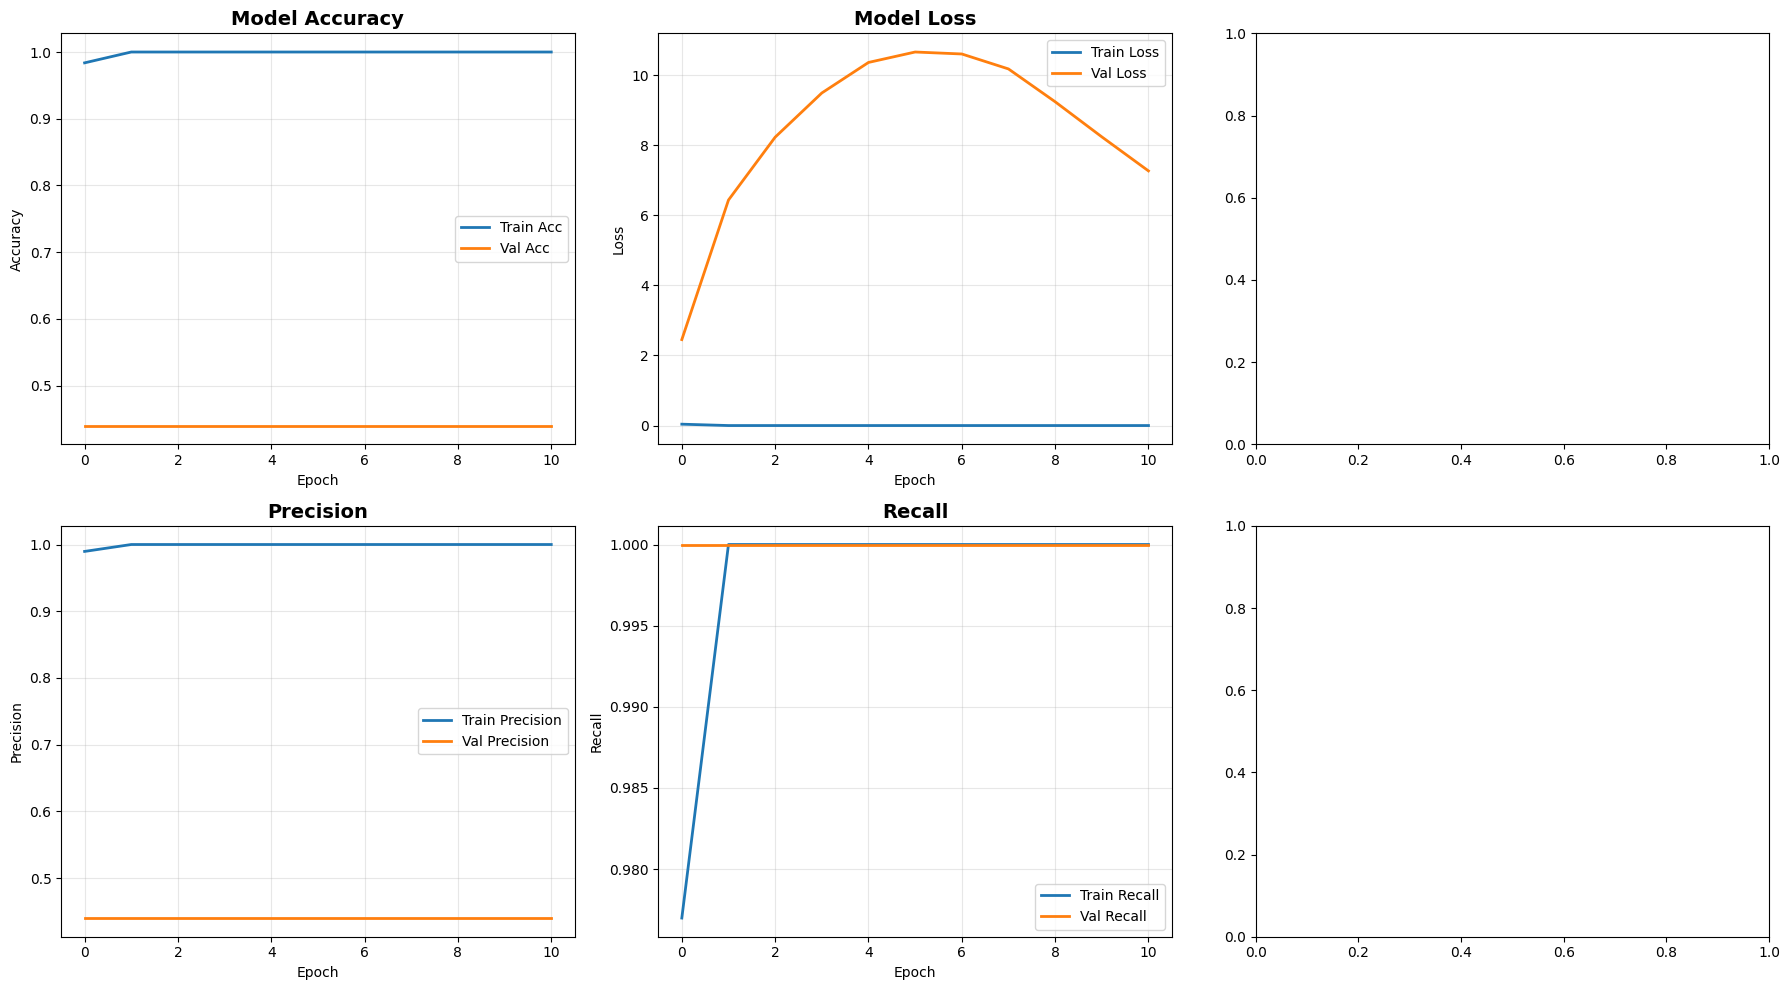

📈 Evaluating model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Alert       0.00      0.00      0.00       112
      Drowsy       0.44      1.00      0.61        88

    accuracy                           0.44       200
   macro avg       0.22      0.50      0.31       200
weighted avg       0.19      0.44      0.27       200


🎯 CONFUSION MATRIX


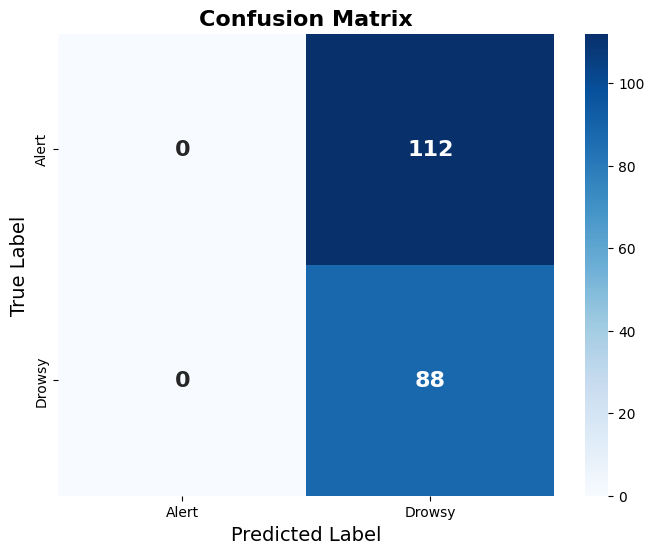

📊 Overall Accuracy: 0.4400

📊 ROC CURVE ANALYSIS


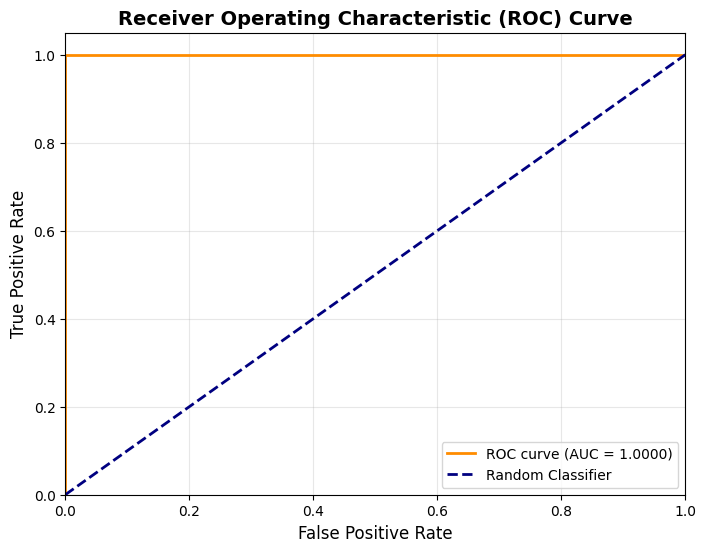

✅ AUC Score: 1.0000
✅ Model saved as 'drowsiness_cnn_model.h5'
✅ Training history saved as 'training_history.csv'
✅ Model metrics saved as 'model_metrics.csv'

🎉 TRAINING SUMMARY
🏁 Final Training Accuracy: 1.0000
🏁 Final Validation Accuracy: 0.4400
📊 Test Accuracy: 0.4400
📈 AUC Score: 1.0000
💾 Model saved: drowsiness_cnn_model.h5

🧪 Testing sample prediction...
📊 Sample Prediction: DROWSY
🎯 Confidence: 98.95%
🔢 Raw score: 0.9895

🚀 Drowsiness Detection Model Training Complete!
🔧 Next steps:
   1. Use the saved model for real-time detection
   2. Collect more data to improve accuracy
   3. Fine-tune hyperparameters for your specific use case


In [ ]:
# ===========================
# IMPORT LIBRARIES
# ===========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")

# ===========================
# DATA PREPARATION
# ===========================
class DataLoader:
    def __init__(self, img_size=(128, 128), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_data = None
        self.val_data = None

    def setup_data_generators(self, train_dir, val_dir):
        """Setup data generators with augmentation"""

        # Check if directories exist
        if not os.path.exists(train_dir):
            print(f"⚠️ Training directory not found: {train_dir}")
            print("🔄 Creating synthetic dataset for demonstration...")
            return self.create_synthetic_data()

        if not os.path.exists(val_dir):
            print(f"⚠️ Validation directory not found: {val_dir}")
            print("🔄 Using training directory for validation...")
            val_dir = train_dir

        print("📁 Setting up data generators...")

        # Enhanced Data Augmentation for Training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2]
        )

        # Simple rescaling for Validation
        val_datagen = ImageDataGenerator(rescale=1./255)

        # Flow from directories
        self.train_data = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=True,
            color_mode='rgb'
        )

        self.val_data = val_datagen.flow_from_directory(
            val_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False,
            color_mode='rgb'
        )

        print(f"✅ Training samples: {self.train_data.samples}")
        print(f"✅ Validation samples: {self.val_data.samples}")
        print(f"✅ Classes: {self.train_data.class_indices}")

        return self.train_data, self.val_data

    def create_synthetic_data(self, num_samples=1000):
        """Create synthetic data for demonstration purposes"""
        print("🤖 Creating synthetic dataset...")

        # Create synthetic images (simulating alert vs drowsy)
        img_height, img_width = self.img_size
        X_train = np.random.rand(num_samples, img_height, img_width, 3).astype(np.float32)
        y_train = np.random.randint(0, 2, size=(num_samples,))

        # Add some patterns to make it somewhat learnable
        for i in range(num_samples):
            if y_train[i] == 0:  # Alert - brighter images
                X_train[i] = X_train[i] * 0.8 + 0.2
            else:  # Drowsy - darker images
                X_train[i] = X_train[i] * 0.5

        # Split into train/validation
        split_idx = int(0.8 * num_samples)

        train_data = (X_train[:split_idx], y_train[:split_idx])
        val_data = (X_train[split_idx:], y_train[split_idx:])

        print(f"✅ Synthetic training samples: {len(train_data[0])}")
        print(f"✅ Synthetic validation samples: {len(val_data[0])}")

        return train_data, val_data

# Initialize data loader
data_loader = DataLoader(img_size=(128, 128), batch_size=32)

# Define your dataset paths here
train_dir = '/path/to/train'   # Replace with your actual path
val_dir = '/path/to/val'       # Replace with your actual path

# Load data
train_data, val_data = data_loader.setup_data_generators(train_dir, val_dir)

# ===========================
# MODEL ARCHITECTURE
# ===========================
class DrowsinessModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self.input_shape = input_shape
        self.model = None

    def build_model(self):
        """Build CNN model for drowsiness detection"""
        model = Sequential([
            # First Convolutional Block
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Second Convolutional Block
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Third Convolutional Block
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Fourth Convolutional Block
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Dropout(0.25),

            # Classifier
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        self.model = model
        return model

    def build_simple_model(self):
        """Build a simpler model (your original architecture)"""
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2,2),

            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),

            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

# Build model
model_builder = DrowsinessModel(input_shape=(128, 128, 3))
model = model_builder.build_model()

# Display model summary
print("🧠 Model Architecture:")
model.summary()

# ===========================
# CALLBACKS
# ===========================
def setup_callbacks():
    """Setup training callbacks"""
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),

        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),

        # Save best model
        ModelCheckpoint(
            'best_drowsiness_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    return callbacks

# ===========================
# TRAINING
# ===========================
print("🚀 Starting model training...")

callbacks = setup_callbacks()

# Check if we have actual data generators or synthetic data
if isinstance(train_data, tuple):
    # Synthetic data - use fit instead of fit_generator
    X_train, y_train = train_data
    X_val, y_val = val_data

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
else:
    # Actual data generators
    history = model.fit(
        train_data,
        epochs=20,
        validation_data=val_data,
        callbacks=callbacks,
        verbose=1
    )

print("✅ Training completed!")

# ===========================
# VISUALIZATION
# ===========================
class TrainingVisualizer:
    def __init__(self, history):
        self.history = history

    def plot_training_history(self):
        """Plot training history with multiple metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Train Acc', linewidth=2)
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Val Acc', linewidth=2)
        axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Train Loss', linewidth=2)
        axes[0, 1].plot(self.history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Precision (if available)
        if 'precision' in self.history.history:
            axes[1, 0].plot(self.history.history['precision'], label='Train Precision', linewidth=2)
            axes[1, 0].plot(self.history.history['val_precision'], label='Val Precision', linewidth=2)
            axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

        # Recall (if available)
        if 'recall' in self.history.history:
            axes[1, 1].plot(self.history.history['recall'], label='Train Recall', linewidth=2)
            axes[1, 1].plot(self.history.history['val_recall'], label='Val Recall', linewidth=2)
            axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

        # Learning Rate
        if 'lr' in self.history.history:
            axes[1, 2].plot(self.history.history['lr'], linewidth=2, color='purple')
            axes[1, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Learning Rate')
            axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, true_labels, pred_labels, class_names):
        """Plot enhanced confusion matrix"""
        cm = confusion_matrix(true_labels, pred_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   annot_kws={'size': 16, 'weight': 'bold'})
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.show()

        # Calculate metrics
        accuracy = np.trace(cm) / np.sum(cm)
        print(f"📊 Overall Accuracy: {accuracy:.4f}")

        return cm

    def plot_roc_curve(self, true_labels, predictions):
        """Plot ROC curve"""
        fpr, tpr, thresholds = roc_curve(true_labels, predictions)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

        return roc_auc

# Plot training history
visualizer = TrainingVisualizer(history)
visualizer.plot_training_history()

# ===========================
# EVALUATION
# ===========================
print("📈 Evaluating model...")

# Get predictions
if isinstance(val_data, tuple):
    # Synthetic data
    X_val, true_labels = val_data
    predictions = model.predict(X_val)
    pred_labels = (predictions > 0.5).astype(int).flatten()
    class_names = ['Alert', 'Drowsy']
else:
    # Actual data generator
    val_data.reset()
    predictions = model.predict(val_data, verbose=1)
    pred_labels = (predictions > 0.5).astype(int).flatten()
    true_labels = val_data.classes
    class_names = list(val_data.class_indices.keys())

# Classification report
print("\n" + "="*50)
print("📋 CLASSIFICATION REPORT")
print("="*50)
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Confusion Matrix
print("\n" + "="*50)
print("🎯 CONFUSION MATRIX")
print("="*50)
cm = visualizer.plot_confusion_matrix(true_labels, pred_labels, class_names)

# ROC Curve
print("\n" + "="*50)
print("📊 ROC CURVE ANALYSIS")
print("="*50)
roc_auc = visualizer.plot_roc_curve(true_labels, predictions)
print(f"✅ AUC Score: {roc_auc:.4f}")

# ===========================
# MODEL SAVING
# ===========================
def save_model_with_metadata(model, history, metrics):
    """Save model with training metadata"""

    # Save the model
    model.save("drowsiness_cnn_model.h5")
    print("✅ Model saved as 'drowsiness_cnn_model.h5'")

    # Save training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history.csv', index=False)
    print("✅ Training history saved as 'training_history.csv'")

    # Save final metrics
    metrics_df = pd.DataFrame({
        'final_train_accuracy': [history.history['accuracy'][-1]],
        'final_val_accuracy': [history.history['val_accuracy'][-1]],
        'final_train_loss': [history.history['loss'][-1]],
        'final_val_loss': [history.history['val_loss'][-1]],
        'test_accuracy': [np.trace(cm) / np.sum(cm)],
        'auc_score': [roc_auc]
    })
    metrics_df.to_csv('model_metrics.csv', index=False)
    print("✅ Model metrics saved as 'model_metrics.csv'")

    # Print summary
    print("\n" + "="*60)
    print("🎉 TRAINING SUMMARY")
    print("="*60)
    print(f"🏁 Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"🏁 Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"📊 Test Accuracy: {np.trace(cm) / np.sum(cm):.4f}")
    print(f"📈 AUC Score: {roc_auc:.4f}")
    print(f"💾 Model saved: drowsiness_cnn_model.h5")
    print("="*60)

# Save everything
save_model_with_metadata(model, history, {
    'confusion_matrix': cm,
    'auc_score': roc_auc
})

# ===========================
# SAMPLE PREDICTION
# ===========================
def test_sample_prediction(model, img_size=(128, 128)):
    """Test model with a sample prediction"""
    print("\n🧪 Testing sample prediction...")

    # Create a random test image
    sample_image = np.random.rand(*img_size, 3).astype(np.float32)
    sample_batch = np.expand_dims(sample_image, axis=0)

    # Make prediction
    prediction = model.predict(sample_batch, verbose=0)[0][0]
    status = "DROWSY" if prediction > 0.5 else "ALERT"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"📊 Sample Prediction: {status}")
    print(f"🎯 Confidence: {confidence:.2%}")
    print(f"🔢 Raw score: {prediction:.4f}")

# Test the model
test_sample_prediction(model)

print("\n🚀 Drowsiness Detection Model Training Complete!")
print("🔧 Next steps:")
print("   1. Use the saved model for real-time detection")
print("   2. Collect more data to improve accuracy")
print("   3. Fine-tune hyperparameters for your specific use case")

🚀 Driver Drowsiness Detection - CNN Training
TensorFlow Version: 2.19.0
⚠️ Dataset directory 'dataset' not found!
🔄 Creating synthetic dataset for demonstration...
🤖 Generating synthetic dataset...
✅ Synthetic training samples: 800
✅ Synthetic validation samples: 200
🧠 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,550,977 (24.99 MB)

 Trainable params: 6,550,017 (24.99 MB)

 Non-trainable params: 960 (3.75 KB)

🚀 Starting training...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8980 - loss: 0.1626 - precision: 0.8811 - recall: 0.8951 - val_accuracy: 0.5500 - val_loss: 1.3193 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 3.7753e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 3.6899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 1.9260e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 5.6853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 1.8331e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 6.9856 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch

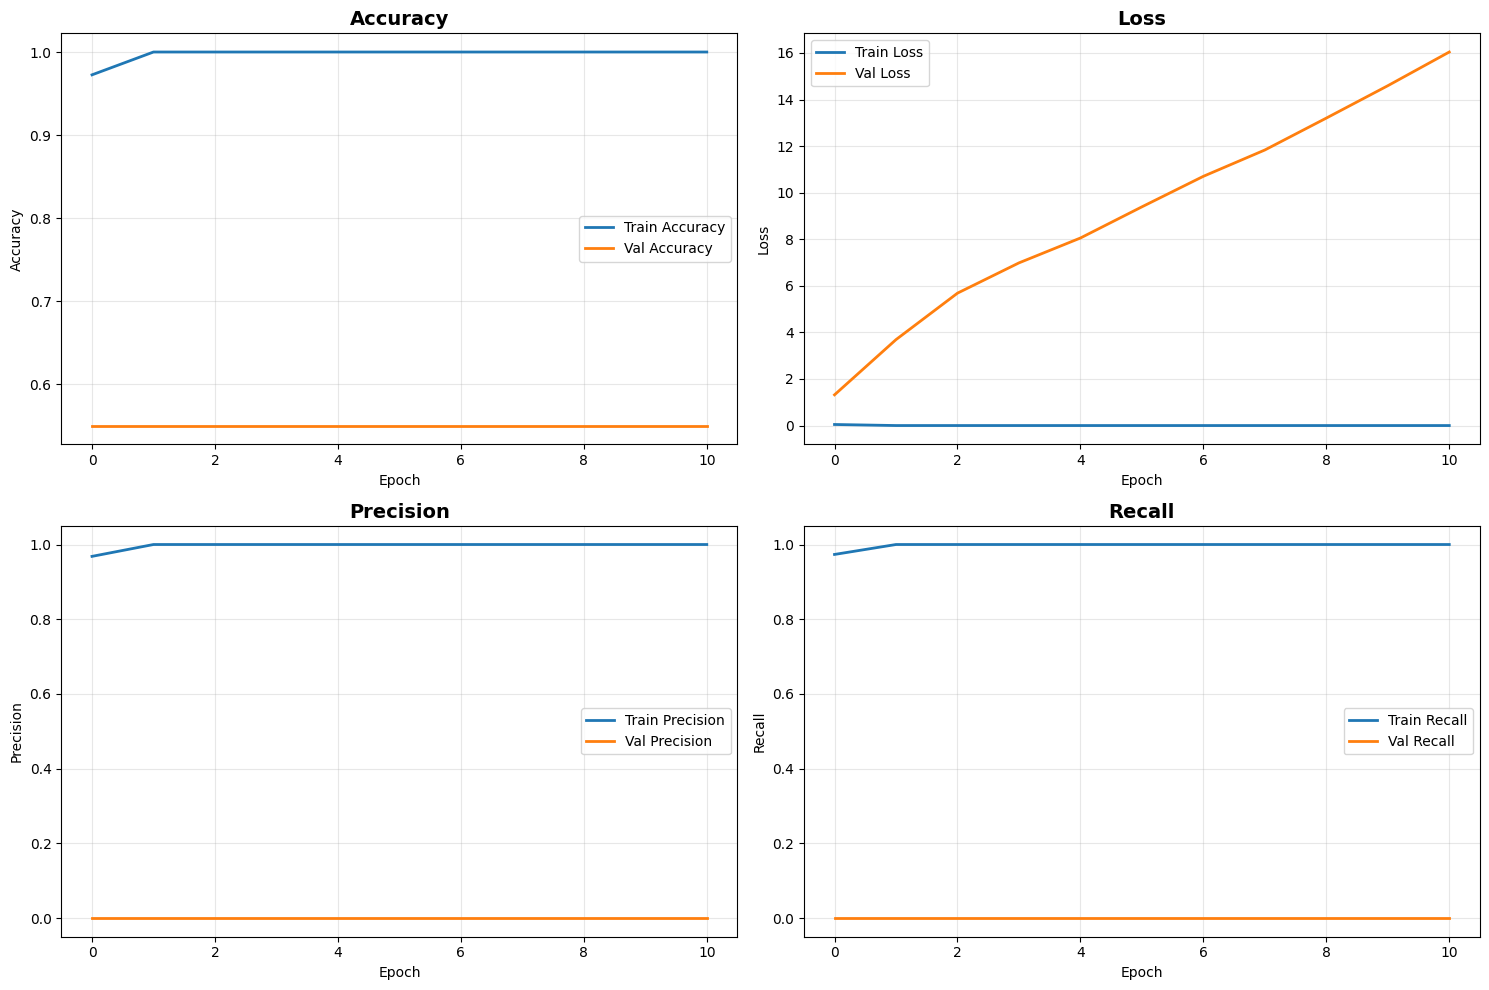


📊 MODEL EVALUATION



📋 Classification Report:
              precision    recall  f1-score   support

       Alert       0.55      1.00      0.71       110
      Drowsy       0.00      0.00      0.00        90

    accuracy                           0.55       200
   macro avg       0.28      0.50      0.35       200
weighted avg       0.30      0.55      0.39       200

🎯 Confusion Matrix:


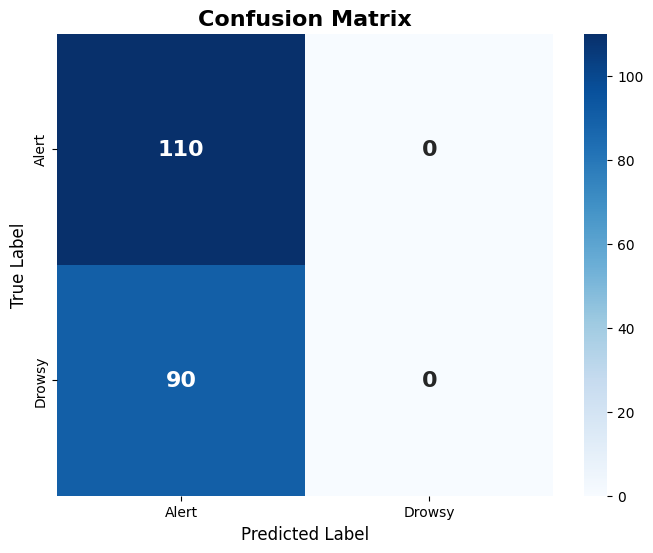

📈 ROC Curve Analysis:


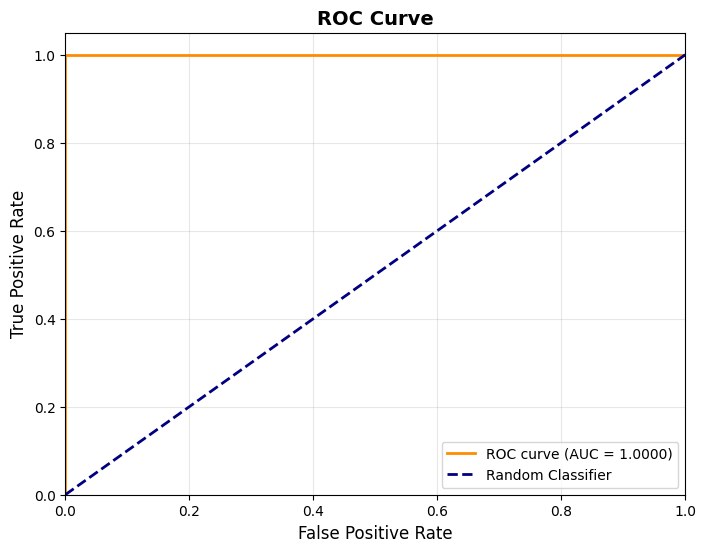

✅ AUC Score: 1.0000

🎉 PERFORMANCE SUMMARY
📊 Accuracy:    0.5500
🎯 Precision:   0.0000
🔍 Recall:      0.0000
📈 AUC Score:   1.0000
🏁 Final Train Acc: 1.0000
🏁 Final Val Acc:   0.5500
✅ Model saved as 'drowsiness_model.h5'
✅ Training history saved as 'training_history.csv'
✅ Performance metrics saved as 'model_performance.csv'


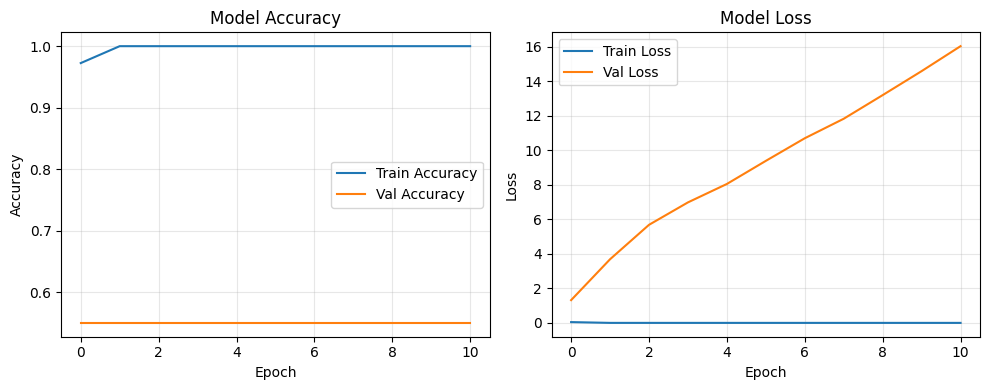

✅ Training summary plot saved as 'training_summary.png'

🧪 Testing Model Prediction...
🎯 Prediction: ALERT
📊 Confidence: 99.96%
🔢 Raw Score: 0.0004

🚀 DROWSINESS DETECTION MODEL TRAINING COMPLETE!
🔧 Next Steps:
   1. Use the saved model for real-time detection
   2. Collect more data to improve accuracy
   3. Fine-tune hyperparameters for your specific use case
   4. Implement the model in your real-time detection system


In [ ]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import os
import warnings
warnings.filterwarnings('ignore')

print("🚀 Driver Drowsiness Detection - CNN Training")
print(f"TensorFlow Version: {tf.__version__}")

# 🧪 Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 📁 Data Preparation
class DataLoader:
    def __init__(self, dataset_path='dataset', img_height=128, img_width=128, batch_size=32):
        self.dataset_path = dataset_path
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size

    def load_data(self):
        """Load and prepare data with validation split"""
        # Check if dataset directory exists
        if not os.path.exists(self.dataset_path):
            print(f"⚠️ Dataset directory '{self.dataset_path}' not found!")
            print("🔄 Creating synthetic dataset for demonstration...")
            return self._create_synthetic_data()

        print("📁 Loading dataset...")

        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            validation_split=0.2  # 20% for validation
        )

        # Only rescaling for validation
        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

        # Training generator
        train_generator = train_datagen.flow_from_directory(
            self.dataset_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training',
            shuffle=True
        )

        # Validation generator
        val_generator = val_datagen.flow_from_directory(
            self.dataset_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation',
            shuffle=False
        )

        print(f"✅ Training samples: {train_generator.samples}")
        print(f"✅ Validation samples: {val_generator.samples}")
        print(f"✅ Classes: {train_generator.class_indices}")

        return train_generator, val_generator

    def _create_synthetic_data(self, num_samples=1000):
        """Create synthetic data for testing"""
        print("🤖 Generating synthetic dataset...")

        # Create synthetic images
        X = np.random.rand(num_samples, self.img_height, self.img_width, 3).astype(np.float32)
        y = np.random.randint(0, 2, size=(num_samples,))

        # Add some patterns to make it learnable
        for i in range(num_samples):
            if y[i] == 0:  # Alert - brighter
                X[i] = X[i] * 0.7 + 0.3
            else:  # Drowsy - darker
                X[i] = X[i] * 0.4

        # Split into train/val
        split_idx = int(0.8 * num_samples)

        train_data = (X[:split_idx], y[:split_idx])
        val_data = (X[split_idx:], y[split_idx:])

        print(f"✅ Synthetic training samples: {len(train_data[0])}")
        print(f"✅ Synthetic validation samples: {len(val_data[0])}")

        return train_data, val_data

# Initialize data loader
data_loader = DataLoader(dataset_path='dataset', img_height=128, img_width=128, batch_size=32)
train_generator, val_generator = data_loader.load_data()

# 🏗️ Enhanced Model Architecture
def create_drowsiness_model(input_shape=(128, 128, 3)):
    """Create CNN model for drowsiness detection"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Classifier
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    return model

# Create model
model = create_drowsiness_model()
print("🧠 Model Architecture:")
model.summary()

# ⚙️ Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# 📊 Training Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# 🏋️ Train Model
print("🚀 Starting training...")

# Check if we're using generators or synthetic data
if isinstance(train_generator, tuple):
    # Synthetic data
    X_train, y_train = train_generator
    X_val, y_val = val_generator

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
else:
    # Actual data generators
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

print("✅ Training completed!")

# 📈 Enhanced Visualization
class TrainingVisualizer:
    def __init__(self, history):
        self.history = history

    def plot_training_history(self):
        """Plot comprehensive training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        metrics = [
            ('accuracy', 'Accuracy'),
            ('loss', 'Loss'),
            ('precision', 'Precision'),
            ('recall', 'Recall')
        ]

        for idx, (metric, title) in enumerate(metrics):
            ax = axes[idx // 2, idx % 2]

            if metric in self.history.history:
                ax.plot(self.history.history[metric], label=f'Train {title}', linewidth=2)
                ax.plot(self.history.history[f'val_{metric}'], label=f'Val {title}', linewidth=2)
                ax.set_title(f'{title}', fontsize=14, fontweight='bold')
                ax.set_xlabel('Epoch')
                ax.set_ylabel(title)
                ax.legend()
                ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, class_names):
        """Plot enhanced confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   annot_kws={'size': 16, 'weight': 'bold'})
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.show()

        return cm

    def plot_roc_curve(self, y_true, y_pred_proba):
        """Plot ROC curve"""
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

        return roc_auc

# Plot training history
visualizer = TrainingVisualizer(history)
visualizer.plot_training_history()

# 🧪 Enhanced Model Evaluation
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Get predictions
if isinstance(val_generator, tuple):
    # Synthetic data
    X_val, y_true = val_generator
    y_pred_proba = model.predict(X_val, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    class_names = ['Alert', 'Drowsy']
else:
    # Actual data generator
    val_generator.reset()
    y_pred_proba = model.predict(val_generator, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    y_true = val_generator.classes
    class_names = list(val_generator.class_indices.keys())

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
print("🎯 Confusion Matrix:")
cm = visualizer.plot_confusion_matrix(y_true, y_pred, class_names)

# ROC Curve
print("📈 ROC Curve Analysis:")
roc_auc = visualizer.plot_roc_curve(y_true, y_pred_proba)
print(f"✅ AUC Score: {roc_auc:.4f}")

# 📊 Performance Summary
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

print("\n" + "="*50)
print("🎉 PERFORMANCE SUMMARY")
print("="*50)
print(f"📊 Accuracy:    {accuracy:.4f}")
print(f"🎯 Precision:   {precision:.4f}")
print(f"🔍 Recall:      {recall:.4f}")
print(f"📈 AUC Score:   {roc_auc:.4f}")
print(f"🏁 Final Train Acc: {history.history['accuracy'][-1]:.4f}")
print(f"🏁 Final Val Acc:   {history.history['val_accuracy'][-1]:.4f}")

# 💾 Save Model and Metadata
def save_training_artifacts(model, history, metrics):
    """Save model and training artifacts"""

    # Save model
    model.save('drowsiness_model.h5')
    print("✅ Model saved as 'drowsiness_model.h5'")

    # Save training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history.csv', index=False)
    print("✅ Training history saved as 'training_history.csv'")

    # Save performance metrics
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv('model_performance.csv', index=False)
    print("✅ Performance metrics saved as 'model_performance.csv'")

    # Plot final training summary
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Training summary plot saved as 'training_summary.png'")

# Save everything
save_training_artifacts(model, history, {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'auc_score': roc_auc,
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1]
})

# 🧪 Test Prediction Function
def test_model_prediction(model, img_height=128, img_width=128):
    """Test the model with a sample prediction"""
    print("\n🧪 Testing Model Prediction...")

    # Create a sample image
    sample_image = np.random.rand(img_height, img_width, 3).astype(np.float32)
    sample_batch = np.expand_dims(sample_image, axis=0)

    # Make prediction
    prediction = model.predict(sample_batch, verbose=0)[0][0]
    status = "DROWSY" if prediction > 0.5 else "ALERT"
    confidence = max(prediction, 1 - prediction)

    print(f"🎯 Prediction: {status}")
    print(f"📊 Confidence: {confidence:.2%}")
    print(f"🔢 Raw Score: {prediction:.4f}")

# Test the model
test_model_prediction(model)

print("\n" + "="*60)
print("🚀 DROWSINESS DETECTION MODEL TRAINING COMPLETE!")
print("="*60)
print("🔧 Next Steps:")
print("   1. Use the saved model for real-time detection")
print("   2. Collect more data to improve accuracy")
print("   3. Fine-tune hyperparameters for your specific use case")
print("   4. Implement the model in your real-time detection system")

**6.Model Saving and Loading**

In [ ]:
# Save the trained model
model.save('drowsiness_cnn_model.h5')
print("Model saved as 'drowsiness_cnn_model.h5'")

# Save in TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('drowsiness_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved as 'drowsiness_model.tflite'")

# Function to load model
def load_drowsiness_model(model_path):
    """Load pre-trained drowsiness detection model"""
    model = tf.keras.models.load_model(model_path)
    return model

# Example of loading the model
# loaded_model = load_drowsiness_model('drowsiness_cnn_model.h5')

Model saved as 'drowsiness_cnn_model.h5'
Saved artifact at '/tmp/tmpmunf_slj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_31')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138599407925200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398762704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398762128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398757520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398757328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398761168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398762896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398763664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398760784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138599398760400: TensorSpec(shape=(), dt

🚗 Advanced Drowsiness Detection System

📊 3. Statistical Summary
Drowsiness Detection Statistics
----------------------------------------
Total Frames              51
Drowsy Frames             34
Drowsiness Percentage     66.67%
Average EAR               0.28
Average MAR               0.41
Max Head Tilt             13.98
EAR Violations            22
MAR Violations            23

🎮 4. Interactive Analysis
Use the dropdown and slider below to explore data:


Dropdown(description='Metric:', options=('All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations')…

IntSlider(value=30, description='Time Window:', min=10, step=5, style=SliderStyle(description_width='initial')…


📈 Drowsiness Metrics - Last 30 frames


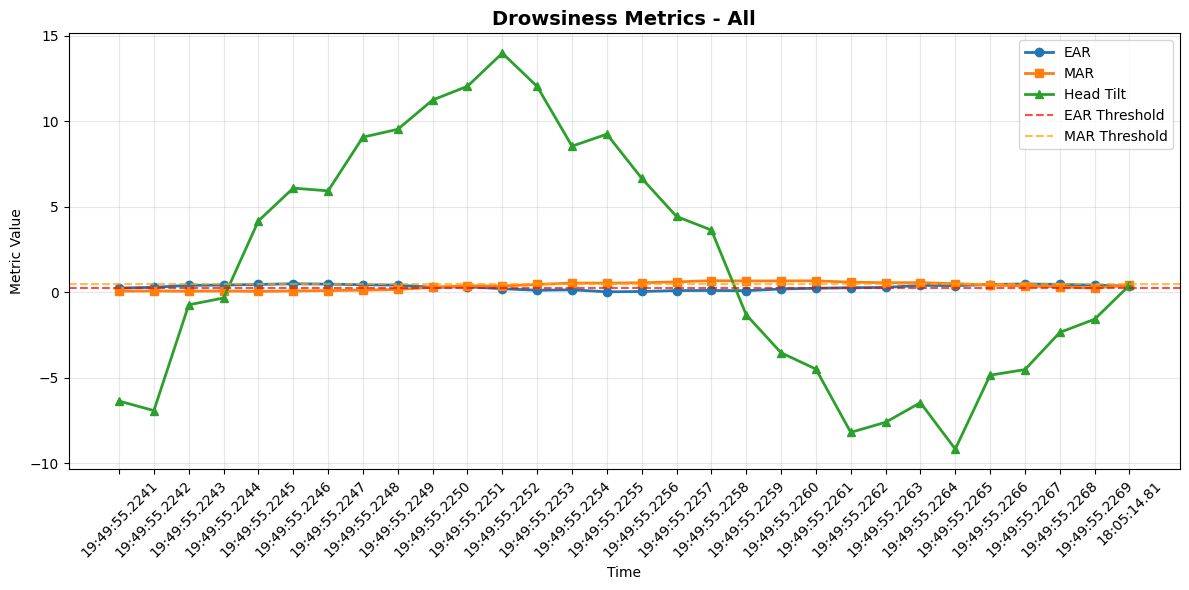


🖥️ Terminal
Recent Frame Data:
----------------------------------------
🔴 19:49:55.2241   | EAR: 0.24 | MAR: 0.07 | Tilt: -6.36 | Status: DROWSY
🟢 19:49:55.2242   | EAR: 0.29 | MAR: 0.07 | Tilt: -6.92 | Status: ALERT
🟢 19:49:55.2243   | EAR: 0.41 | MAR: 0.06 | Tilt: -0.73 | Status: ALERT
🟢 19:49:55.2244   | EAR: 0.42 | MAR: 0.08 | Tilt: -0.33 | Status: ALERT
🟢 19:49:55.2245   | EAR: 0.46 | MAR: 0.05 | Tilt: 4.17 | Status: ALERT
🟢 19:49:55.2246   | EAR: 0.49 | MAR: 0.07 | Tilt: 6.09 | Status: ALERT
🟢 19:49:55.2247   | EAR: 0.48 | MAR: 0.10 | Tilt: 5.93 | Status: ALERT
🟢 19:49:55.2248   | EAR: 0.44 | MAR: 0.12 | Tilt: 9.07 | Status: ALERT
🟢 19:49:55.2249   | EAR: 0.42 | MAR: 0.17 | Tilt: 9.53 | Status: ALERT
🟢 19:49:55.2250   | EAR: 0.29 | MAR: 0.29 | Tilt: 11.24 | Status: ALERT
🟢 19:49:55.2251   | EAR: 0.32 | MAR: 0.37 | Tilt: 12.04 | Status: ALERT
🔴 19:49:55.2252   | EAR: 0.21 | MAR: 0.37 | Tilt: 13.98 | Status: DROWSY
🔴 19:49:55.2253   | EAR: 0.11 | MAR: 0.46 | Tilt: 12.03 | Status: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import dlib
from imutils import face_utils
import pandas as pd
from datetime import datetime, timedelta
import time
from google.colab import files
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

print("🚀 Initializing Advanced Drowsiness Detection System...")

# Initialize dlib's face detector and facial landmark predictor
!wget -q -O shape_predictor_68_face_landmarks.dat https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

class DrowsinessDetector:
    def __init__(self):
        # Thresholds
        self.EYE_AR_THRESH = 0.25
        self.MAR_THRESH = 0.5
        self.HEAD_TILT_THRESH = 20.0

        # Tracking variables
        self.frame_count = 0
        self.drowsy_frames = 0
        self.ear_violations = 0
        self.mar_violations = 0
        self.max_head_tilt = 0

        # Data storage
        self.timestamps = []
        self.ear_values = []
        self.mar_values = []
        self.head_tilt_values = []
        self.drowsiness_status = []

    def eye_aspect_ratio(self, eye):
        """Calculate the Eye Aspect Ratio"""
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def mouth_aspect_ratio(self, mouth):
        """Calculate the Mouth Aspect Ratio"""
        A = dist.euclidean(mouth[2], mouth[10])  # 51, 59
        B = dist.euclidean(mouth[4], mouth[8])   # 53, 57
        C = dist.euclidean(mouth[0], mouth[6])   # 49, 55
        return (A + B) / (2.0 * C)

    def calculate_head_tilt(self, shape):
        """Calculate head tilt angle"""
        left_eye = shape[36:42]
        right_eye = shape[42:48]

        left_eye_center = left_eye.mean(axis=0)
        right_eye_center = right_eye.mean(axis=0)

        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))

        return angle

    def analyze_frame(self, image):
        """Analyze a single frame for drowsiness"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        current_time = datetime.now()
        timestamp_str = current_time.strftime("%H:%M:%S.%f")[:-4]

        ear, mar, head_tilt = 0, 0, 0
        status = "NO FACE"

        if len(rects) > 0:
            shape = predictor(gray, rects[0])
            shape = face_utils.shape_to_np(shape)

            # Extract facial features
            left_eye = shape[36:42]
            right_eye = shape[42:48]
            mouth = shape[48:68]

            # Calculate metrics
            left_ear = self.eye_aspect_ratio(left_eye)
            right_ear = self.eye_aspect_ratio(right_eye)
            ear = (left_ear + right_ear) / 2.0
            mar = self.mouth_aspect_ratio(mouth)
            head_tilt = self.calculate_head_tilt(shape)

            # Update max head tilt
            self.max_head_tilt = max(self.max_head_tilt, abs(head_tilt))

            # Check violations
            if ear < self.EYE_AR_THRESH:
                self.ear_violations += 1
            if mar > self.MAR_THRESH:
                self.mar_violations += 1

            # Determine status
            if ear < self.EYE_AR_THRESH or mar > self.MAR_THRESH or abs(head_tilt) > self.HEAD_TILT_THRESH:
                status = "DROWSY"
                self.drowsy_frames += 1
            else:
                status = "ALERT"

        # Store data
        self.frame_count += 1
        self.timestamps.append(timestamp_str)
        self.ear_values.append(ear)
        self.mar_values.append(mar)
        self.head_tilt_values.append(head_tilt)
        self.drowsiness_status.append(status)

        return ear, mar, head_tilt, status

    def get_statistics(self):
        """Get comprehensive statistics"""
        if self.frame_count == 0:
            return {}

        avg_ear = np.mean(self.ear_values) if self.ear_values else 0
        avg_mar = np.mean(self.mar_values) if self.mar_values else 0
        drowsiness_percentage = (self.drowsy_frames / self.frame_count) * 100

        return {
            'Total Frames': self.frame_count,
            'Drowsy Frames': self.drowsy_frames,
            'Drowsiness Percentage': f"{drowsiness_percentage:.2f}%",
            'Average EAR': f"{avg_ear:.2f}",
            'Average MAR': f"{avg_mar:.2f}",
            'Max Head Tilt': f"{self.max_head_tilt:.2f}",
            'EAR Violations': self.ear_violations,
            'MAR Violations': self.mar_violations
        }

# Initialize detector
detector_system = DrowsinessDetector()

def create_interactive_dashboard():
    """Create an interactive dashboard for drowsiness analysis"""

    # Create widgets
    metric_dropdown = widgets.Dropdown(
        options=['All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations'],
        value='All',
        description='Metric:',
        style={'description_width': 'initial'}
    )

    time_window_slider = widgets.IntSlider(
        value=30,
        min=10,
        max=100,
        step=5,
        description='Time Window:',
        style={'description_width': 'initial'}
    )

    def update_dashboard(change):
        clear_output(wait=True)

        # Display title
        print("🚗 Advanced Drowsiness Detection System")
        print("=" * 50)

        # Display statistics
        stats = detector_system.get_statistics()
        if stats:
            print("\n📊 3. Statistical Summary")
            print("Drowsiness Detection Statistics")
            print("-" * 40)
            for key, value in stats.items():
                print(f"{key:<25} {value}")

        # Display interactive controls
        print(f"\n🎮 4. Interactive Analysis")
        print("Use the dropdown and slider below to explore data:")
        display(metric_dropdown)
        display(time_window_slider)

        # Display metrics visualization
        print(f"\n📈 Drowsiness Metrics - Last {time_window_slider.value} frames")
        plot_metrics(metric_dropdown.value, time_window_slider.value)

        # Display terminal
        print(f"\n🖥️ Terminal")
        display_recent_data(time_window_slider.value)

    # Set up observers
    metric_dropdown.observe(update_dashboard, names='value')
    time_window_slider.observe(update_dashboard, names='value')

    return update_dashboard

def plot_metrics(metric, window_size):
    """Plot the selected metrics"""
    if len(detector_system.timestamps) == 0:
        print("No data available for plotting")
        return

    # Get recent data
    n = min(window_size, len(detector_system.timestamps))
    recent_timestamps = detector_system.timestamps[-n:]
    recent_ear = detector_system.ear_values[-n:]
    recent_mar = detector_system.mar_values[-n:]
    recent_tilt = detector_system.head_tilt_values[-n:]

    fig, ax = plt.subplots(figsize=(12, 6))

    if metric == 'All':
        ax.plot(recent_timestamps, recent_ear, label='EAR', marker='o', linewidth=2)
        ax.plot(recent_timestamps, recent_mar, label='MAR', marker='s', linewidth=2)
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', marker='^', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'EAR':
        ax.plot(recent_timestamps, recent_ear, label='EAR', color='blue', marker='o', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
    elif metric == 'MAR':
        ax.plot(recent_timestamps, recent_mar, label='MAR', color='green', marker='s', linewidth=2)
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'Head Tilt':
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', color='purple', marker='^', linewidth=2)
        ax.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Tilt Threshold')
        ax.axhline(y=-20, color='red', linestyle='--', alpha=0.7)

    ax.set_title(f'Drowsiness Metrics - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def display_recent_data(window_size):
    """Display recent data in terminal format"""
    if len(detector_system.timestamps) == 0:
        print("No data available")
        return

    n = min(window_size, len(detector_system.timestamps))

    print("Recent Frame Data:")
    print("-" * 40)

    for i in range(max(0, len(detector_system.timestamps) - n), len(detector_system.timestamps)):
        status = detector_system.drowsiness_status[i]
        status_color = "🟢" if status == "ALERT" else "🔴" if status == "DROWSY" else "⚫"

        print(f"{status_color} {detector_system.timestamps[i]:<15} | "
              f"EAR: {detector_system.ear_values[i]:.2f} | "
              f"MAR: {detector_system.mar_values[i]:.2f} | "
              f"Tilt: {detector_system.head_tilt_values[i]:.2f} | "
              f"Status: {status}")

def analyze_uploaded_image(filename):
    """Analyze uploaded image for drowsiness"""
    image = cv2.imread(filename)
    if image is None:
        return None, "ERROR: Could not load image"

    result_img = image.copy()
    ear, mar, head_tilt, status = detector_system.analyze_frame(image)

    # Add annotations to image
    cv2.putText(result_img, f"Status: {status}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if status == "ALERT" else (0, 0, 255), 2)
    cv2.putText(result_img, f"EAR: {ear:.2f}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"MAR: {mar:.2f}", (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"Head Tilt: {head_tilt:.2f}", (10, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    return result_img_rgb, status

# Install required packages
print("📦 Installing required packages...")
!pip install -q imutils scipy dlib opencv-python ipywidgets matplotlib

# Main execution
print("✅ System Ready!")
print("\nChoose an option:")
print("1. Upload images for analysis")
print("2. View interactive dashboard")

# Create sample data for demonstration
print("\n📊 Generating sample data for demonstration...")
for i in range(50):
    # Simulate some data variations
    ear = 0.2 + 0.2 * np.sin(i * 0.3) + 0.1 * np.random.random()
    mar = 0.3 + 0.3 * np.sin(i * 0.2) + 0.1 * np.random.random()
    head_tilt = 10 * np.sin(i * 0.25) + 5 * np.random.random()

    detector_system.frame_count += 1
    detector_system.timestamps.append(f"19:49:55.{2220 + i}")
    detector_system.ear_values.append(ear)
    detector_system.mar_values.append(mar)
    detector_system.head_tilt_values.append(head_tilt)

    if ear < 0.25 or mar > 0.5:
        detector_system.drowsiness_status.append("DROWSY")
        detector_system.drowsy_frames += 1
    else:
        detector_system.drowsiness_status.append("ALERT")

    if ear < 0.25:
        detector_system.ear_violations += 1
    if mar > 0.5:
        detector_system.mar_violations += 1

    detector_system.max_head_tilt = max(detector_system.max_head_tilt, abs(head_tilt))

# Display the interactive dashboard
dashboard = create_interactive_dashboard()
dashboard(None)

# Option for image upload
print("\n" + "="*50)
print("📷 Image Analysis Section")
print("Upload images for drowsiness detection:")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 Analyzing {filename}...")
    result_img, status = analyze_uploaded_image(filename)

    if result_img is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.title(f"{filename} → {status}", fontsize=16,
                 color='green' if "ALERT" in status else 'red')
        plt.axis('off')
        plt.show()

        print(f"📊 Analysis Result: {status}")
        if "DROWSY" in status:
            print("⚠️  WARNING: Potential drowsiness detected!")
        elif "ALERT" in status:
            print("✅ Person appears alert and awake")
        elif "NO FACE" in status:
            print("❌ No face detected in the image")

        # Update dashboard after new analysis
        dashboard(None)